In [2]:
"""
Largely followed methodology outlined in this paper:
"A Complex Classification Approach of Partial Discharges from Covered Conductors in Real Environment"
2017
S. Mišák, J. Fulneček, T. Vantuch, T. Buriánek and T. Ježowicz
Preprint version available here:
https://www.dropbox.com/s/2ltuvpw1b1ms2uu/A%20Complex%20Classification%20Approach%20of%20Partial%20Discharges%20from%20Covered%20Conductors%20in%20Real%20Environment%20%28preprint%29.pdf?dl=0

More details of the methodology from the paper above are provided in this thesis:
"Analysis of Time Series Data"
Tomáš Vantuch
2018
Available here:
http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf

Began with kernel from:
https://www.kaggle.com/jackvial/dwt-signal-denoising
to start with Discrete Wavelet Transform denoising/peak identification
"""

# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pyarrow.parquet as pq
import gc
import pywt
from statsmodels.robust import mad
import scipy
from scipy import signal
from scipy.signal import butter, find_peaks
from scipy import fftpack # Fast Fourier Transform functions
import os.path
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, make_scorer, matthews_corrcoef
from sklearn.model_selection import cross_val_score
import warnings

# Suppress pandas future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define data directory
data_dir = '../input'

# Print scipy version - 1.1.0 at time of creation
print(scipy.__version__)

1.1.0


# Define Functions

**Calculate Mean Absolute Deviation**  
maddest()

**Synchronise All Waveforms**  
sync_phase()

**High Pass Filter**  
high_pass_filter()

**Discrete Wavelet Transform Denoising**  
denoise_signal()

**Cancel False Peaks**  
cancel_false_peaks()

**Extract Peak and Valley Features:**  
pv_features()

In [3]:
# 800,000 data points taken over 20 ms
# Grid operates at 50hz, 0.02 * 50 = 1, so 800k samples in 20 milliseconds will capture one complete cycle
n_samples = 800000

# Sample duration is 20 miliseconds
sample_duration = 0.02

# Sample rate is the number of samples in one second
# Sample rate will be 40mhz
sample_rate = n_samples * (1 / sample_duration)

# time array support
t = np.array([i / sample_rate for i in range(n_samples)])

# frequency vector for FFT
freqs = fftpack.fftfreq(n_samples, d=1/sample_rate)

# Mean Absolute Deviation
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

# Synchronise all waveforms
# Adapted from https://www.kaggle.com/fernandoramacciotti/sync-waves-with-fft-coeffs
def sync_phase(x, align_value=0.5):
    
    # fft
    fft_coeffs = fftpack.fft(x)
    
    # asses dominant frequency
    coeff_norms = np.abs(fft_coeffs)  # get norms (fft coeffs are complex)
    max_idx = np.argmax(coeff_norms)
    max_coeff = fft_coeffs[max_idx]  # get max coeff
    max_freq = freqs[max_idx]  # assess which is the dominant frequency
    max_amp = (coeff_norms[max_idx] / n_samples) * 2  # times 2 because there are mirrored freqs
    if max_freq != 50:
        # print('Dominant frequency is {:,.1f}Hz with amplitude of {:,.1f}\n'.format(max_freq, max_amp))
        # print('Signal ID is {:,.1f} and its target is {:,.1f}\n'.format(metadata_train.signal_id[i], metadata_train.target[i]))
        return x, max_freq
    else:
            
        # phase shift
        phase_shift = np.angle(max_coeff)
    
        # get angular phase vector
        w = 2 * np.pi * t * max_freq + phase_shift
        w_norm = np.mod(w / (2 * np.pi), 1) * 2  # range between cycle of 0-2
    
        # idx to roll
        candidates = np.where(np.isclose(w_norm, align_value))
        # since we are in discrete time, threre could be many values close to the desired one
        # so take the median
        origin = int(np.median(candidates))
    
        # roll/sync signal
        sig_rolled = np.roll(x, n_samples - origin)
        return sig_rolled, max_freq

# High Pass Filter
# Adapted from https://github.com/randxie/Kaggle-VSB-Baseline/blob/master/src/utils/util_signal.py
def high_pass_filter(x, low_cutoff=1000, sample_rate=sample_rate):  # 1000 is default, correctly set to 10^4 below 
    
    # nyquist frequency (half the sample rate)
    nyquist = 0.5 * sample_rate
    norm_low_cutoff = low_cutoff / nyquist
    
    # Fault pattern usually exists in high frequency band. 
    # According to literature, the pattern is visible above 10^4 Hz.
    # For digital filters, Wn is normalized from 0 to 1, 
    # where 1 is the Nyquist frequency, pi radians/sample (Wn is thus in half-cycles / sample).
    sos = butter(10, Wn=[norm_low_cutoff], btype='highpass', output='sos')
    filtered_sig = signal.sosfilt(sos, x)

    return filtered_sig

# Discrete Wavelet Transform Denoising
# 1. Adapted from waveletSmooth function found here:
# http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
# 2. Threshold equation and using hard mode in threshold as mentioned
# in section '3.2 denoising based on optimized singular values' from the Vantuch thesis 
def denoise_signal(x, wavelet='db4', level=1):

    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec(x, wavelet, mode="per" )
    
    # Calculate sigma for threshold as defined in the Vantuch thesis, using Mean Absolute Deviation
    sigma = (1/0.6745) * maddest( coeff[-level] )  # eqn 3.8 

    # Calculte the univeral threshold
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )  # eqn 3.9
    coeff[1:] = (pywt.threshold( i, value=uthresh, mode='hard' ) for i in coeff[1:] )
    
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec(coeff, wavelet, mode='per')

# Cancel False Peaks
# Such as those from corona discharges
# Adapted from https://www.kaggle.com/jeffreyegan/vsb-power-line-fault-detection-approach
def cancel_false_peaks(signal, peak_indexes, min_height_fp=50):

    false_peak_indexes = []
    min_height_fp = min_height_fp
    max_sym_distance = 20 
    max_pulse_train = 750  
    max_height_ratio = 1.25 
    min_height_ratio = 0.25
    for pk in range(len(peak_indexes)-1):
        if not peak_indexes[pk] in false_peak_indexes:
            if (signal[peak_indexes[pk]] > min_height_fp and signal[peak_indexes[pk+1]] < 0) and (peak_indexes[pk+1] - peak_indexes[pk]) < max_sym_distance:
                # if 1 > abs(signal[peak_indexes[pk+1]])/abs(signal[peak_indexes[pk]]) > max_height_ratio:
                if max_height_ratio > abs(signal[peak_indexes[pk+1]])/abs(signal[peak_indexes[pk]]) > min_height_ratio:
                    for x in range(len(peak_indexes)):
                        if peak_indexes[pk] <= peak_indexes[x] <= peak_indexes[pk]+max_pulse_train:
                            false_peak_indexes.append(peak_indexes[x]) 
                        
            if (signal[peak_indexes[pk]] < -min_height_fp and signal[peak_indexes[pk+1]] > 0) and (peak_indexes[pk+1] - peak_indexes[pk]) < max_sym_distance:
                if max_height_ratio > abs(signal[peak_indexes[pk+1]])/abs(signal[peak_indexes[pk]]) > min_height_ratio:
                    for x in range(len(peak_indexes)):
                        if peak_indexes[pk] <= peak_indexes[x] <= peak_indexes[pk]+max_pulse_train:
                            false_peak_indexes.append(peak_indexes[x])
                            
    true_peak_indexes = list(set(peak_indexes) - set(false_peak_indexes))
    
    return np.array(true_peak_indexes, dtype=np.int32), np.array(false_peak_indexes, dtype=np.int32)


# Extract Peak and Valley Features
def pv_features(x_dn, pv_true, peaks, valleys, rel_height=0.2):

    # p=peaks, v=valleys, h=height, w=width
    true_peaks = np.array(list(set(peaks) & set(pv_true)), dtype=np.int32)  # intersection of true peaks/valleys and peaks
    if true_peaks.shape[0] == 0:
        p_n = 0 
        ph_mean = 0
        ph_max = 0
        pw_mean = 0
        pw_max = 0
    else:
        p_n = true_peaks.shape[0]
        peak_heights, _ , _ = signal.peak_prominences(x_dn, true_peaks)
        peak_heights = np.vstack((x_dn[true_peaks], peak_heights)).min(axis=0)
        ph_mean = peak_heights.mean()
        ph_max = peak_heights.max()
        peak_widths, peak_width_heights, peak_left_ips , peak_right_ips = signal.peak_widths(x_dn, true_peaks, rel_height=rel_height)
        pw_mean = peak_widths.mean()
        pw_max = peak_widths.max()
    
    true_valleys = np.array(list(set(valleys) & set(pv_true)), dtype=np.int32)  # intersection of true peaks/valleys and valleys
    if true_valleys.shape[0] == 0:
        v_n = 0 
        vh_mean = 0
        vh_max = 0
        vw_mean = 0
        vw_max = 0
    else:
        v_n = true_valleys.shape[0]
        valley_heights, _ , _ = signal.peak_prominences(-x_dn, true_valleys)
        valley_heights = np.vstack((-x_dn[true_valleys], valley_heights)).min(axis=0)
        vh_mean = valley_heights.mean()
        vh_max = valley_heights.max()
        valley_widths, valley_width_heights, valley_left_ips , valley_right_ips = signal.peak_widths(-x_dn, true_valleys, rel_height=rel_height)
        vw_mean = valley_widths.mean()
        vw_max = valley_widths.max()
        
    return np.array([p_n, ph_mean, ph_max, pw_mean, pw_max, v_n, vh_mean, vh_max, vw_mean, vw_max])
    

### Import Train Metadata

In [4]:
metadata_train = pd.read_csv(data_dir + '/metadata_train.csv')
metadata_train.head()

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1


**Check number of phases on which a fault occurs**  
The majority of faults (target=1) occur on all 3 phases

In [5]:
metadata_train.groupby(["id_measurement"]).sum()['target'].value_counts()

0    2710
3     156
1      19
2      19
Name: target, dtype: int64

### Import Small Subset of Train Data for Exploration

In [6]:
subset_train = pq.read_pandas(data_dir + '/train.parquet', columns=[str(i) for i in range(21)]).to_pandas()
subset_train.shape

(800000, 21)

### Plot the Target Variable Counts by Phase

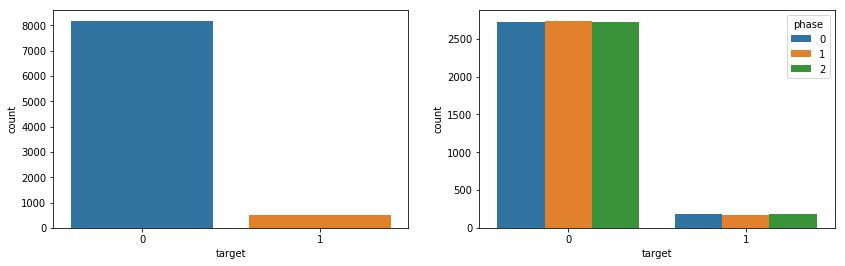

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sns.countplot(x="target", data=metadata_train, ax=ax1)
sns.countplot(x="target", data=metadata_train, hue="phase", ax=ax2)

# Exploratory Plot 1
**Plot the first six signals** (all 3 phases of the first 2 measurement IDs)  
Measurement ID 1 - no faults  
Measurement ID 2 -faults on all 3 phases  
Each row of plots has the original signal (left), high pass signal (middle), and high pass and DWT denoised signal (right).  
Two rows are plotted for each signal: complete signal in the first row, and zoomed in signal in the second row.  

In [ ]:
train_length = 6
for i in range(train_length):
    signal_id = str(i)
    meta_row = metadata_train[metadata_train['signal_id'] == i]
    measurement = str(meta_row['id_measurement'].values[0])
    signal_id = str(meta_row['signal_id'].values[0])
    phase = str(meta_row['phase'].values[0])
        
    # Synchronize waveforms
    x_sync, dominant_frequency = sync_phase(subset_train[signal_id])
    
    # Apply high pass filter with low cutoff of 10kHz, this will remove the low frequency 50Hz sinusoidal motion in the signal
    x_hp = high_pass_filter(x_sync, low_cutoff=10000, sample_rate=sample_rate)
    
    # Apply denoising
    x_dn = denoise_signal(x_hp, wavelet='haar', level=1)
    
    slice_size = 10000
    font_size = 16
    
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 10))
    
    ax[0, 0].plot(x_sync, alpha=0.5)
    ax[0, 0].set_title(f"measurement id: {measurement}, signal id: {signal_id}, phase: {phase}", fontsize=font_size)
    ax[0, 0].legend(['Original'], fontsize=font_size)
    
    # Show smaller slice of the signal to get a better idea of the effect the high pass frequency filter is having on the signal
    ax[1, 0].plot(x_sync[:slice_size], alpha=0.5)
    ax[1, 0].set_title(f"measurement id: {measurement}, signal id: {signal_id}, phase: {phase}", fontsize=font_size)
    ax[1, 0].legend([f"Original n: {slice_size}"], fontsize=font_size)
    
    ax[0, 1].plot(x_hp, 'r', alpha=0.5)
    ax[0, 1].set_title(f"measurement id: {measurement}, signal id: {signal_id}, phase: {phase}", fontsize=font_size)
    ax[0, 1].legend(['HP filter'], fontsize=font_size)
    ax[1, 1].plot(x_hp[:slice_size], 'r', alpha=0.5)
    ax[1, 1].set_title(f"measurement id: {measurement}, signal id: {signal_id}, phase: {phase}", fontsize=font_size)
    ax[1, 1].legend([f"HP filter n: {slice_size}"], fontsize=font_size)
    
    ax[0, 2].plot(x_dn, 'g', alpha=0.5)
    ax[0, 2].set_title(f"measurement id: {measurement}, signal id: {signal_id}, phase: {phase}", fontsize=font_size)
    ax[0, 2].legend(['HP filter and denoising'], fontsize=font_size)
    ax[1, 2].plot(x_dn[:slice_size], 'g', alpha=0.5)
    ax[1, 2].set_title(f"measurement id: {measurement}, signal id: {signal_id}, phase: {phase}", fontsize=font_size)
    ax[1, 2].legend([f"HP filter and denoising n: {slice_size}"], fontsize=font_size)
    
    plt.show()

# Exploratory Plot 2
**Plot the first 21 signals (filtered and denoised) zoomed in on 2000 out of 800000 points to see peak detail and canceled peaks**  
peaks (and valleys) marked with a blue x  
canceled false peaks marked with a red x  
peak widths and heights indicated by an orange line  
faults on all three phases of measurement ID 1 only 



In [ ]:
train_length = subset_train.shape[1]

for i in range(train_length):
    signal_id = str(i)
    meta_row = metadata_train[metadata_train['signal_id'] == i]
    measurement = str(meta_row['id_measurement'].values[0])
    signal_id = str(meta_row['signal_id'].values[0])
    phase = str(meta_row['phase'].values[0])
    target = str(meta_row['target'].values[0])
    
    subset_train_row = subset_train[signal_id]
    
    # Apply high pass filter with low cutoff of 10kHz, this will remove the low frequency 50Hz sinusoidal motion in the signal
    x_hp = high_pass_filter(subset_train_row, low_cutoff=10000, sample_rate=sample_rate)
    
    # Apply denoising
    x_dn = denoise_signal(x_hp, wavelet='haar', level=1)
    
    start = 116000
    slice_size = 2000
    
    # Find peaks
    peaks, peak_properties = find_peaks(x_dn[start:start+slice_size], height=0.1, width=0, rel_height=0.2)
    valleys, valley_properties = find_peaks(-x_dn[start:start+slice_size], height=0.1, width=0, rel_height=0.2)
    all_peaks = np.sort(np.concatenate((peaks, valleys)))
    
    # Cancel false peaks
    true_pv, false_pv = cancel_false_peaks(x_dn[start:start+slice_size], all_peaks, min_height_fp=15)
    true_peaks = np.array(list(set(peaks) & set(true_pv)), dtype=np.int32)  # intersection of true peaks/valleys and peaks
    true_valleys = np.array(list(set(valleys) & set(true_pv)), dtype=np.int32)  # intersection of true peaks/valleys and valleys 
    
    # Calculate heights and widths of true peaks
    peak_heights, _ , _ = signal.peak_prominences(x_dn[start:start+slice_size], true_peaks)
    peak_heights = np.vstack((x_dn[start+true_peaks], peak_heights)).min(axis=0)
    peak_widths, peak_width_heights, peak_left_ips , peak_right_ips = signal.peak_widths(x_dn[start:start+slice_size], true_peaks, rel_height=0.2)
    
    valley_heights, _ , _ = signal.peak_prominences(-x_dn[start:start+slice_size], true_valleys)
    valley_heights = np.vstack((-x_dn[start+true_valleys], valley_heights)).min(axis=0)
    valley_widths, valley_width_heights, valley_left_ips , valley_right_ips = signal.peak_widths(-x_dn[start:start+slice_size], true_valleys, rel_height=0.2)
    
    # Plot
    font_size = 16
    plt.figure(figsize=(30,8))
    plt.plot(x_dn[start:start+slice_size], 'g', alpha=0.5)
    plt.scatter(true_peaks, x_dn[start+true_peaks], marker="x", color="b", label="True Peaks")
    plt.scatter(false_pv, x_dn[start+false_pv], marker="x", color="red", label="Cancelled Peaks")
    plt.vlines(x=true_peaks, ymin=x_dn[start+true_peaks] - peak_heights, ymax = x_dn[start+true_peaks], color = "C1")
    plt.hlines(y=peak_width_heights, xmin=peak_left_ips, xmax=peak_right_ips, color = "C1")
    ## Valleys
    plt.scatter(true_valleys, x_dn[start+true_valleys], marker="x", color="b", label="True Valleys")
    plt.vlines(x=true_valleys, ymin=x_dn[start+true_valleys] , ymax = x_dn[start+true_valleys] + valley_heights, color = "C1")
    plt.hlines(y=-valley_width_heights, xmin=valley_left_ips, xmax=valley_right_ips, color = "C1")
    
    plt.title(f"measurement id: {measurement}, signal id: {signal_id}, phase: {phase}, target: {target}", fontsize=font_size)
    plt.show()


# Load Train Dataset
**Note: dataset occupies 6.5GB of RAM, but ~15GB is needed while loading the dataset**  
If you do not have this much RAM available, load and process the data in chunks as I have done with the larger test set below

In [8]:
train = pq.read_pandas(data_dir + '/train.parquet').to_pandas()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Columns: 8712 entries, 0 to 8711
dtypes: int8(8712)
memory usage: 6.5 GB


# Train Set: Filter, Denoise, and Extract Features
**Note: this can take over 30 minutes**


In [10]:
%%time
train_length = train.shape[1]  # 8712
train_features = np.empty((train_length, 44))
height = (2, 100)
rel_height = 0.2

for i in range(train_length):
    signal_id = str(i)
    
    # Synchronize phases
    x_sync, dominant_frequency = sync_phase(train[signal_id])
    
    # Apply high pass filter with low cutoff of 10kHz
    x_hp = high_pass_filter(x_sync, low_cutoff=10000, sample_rate=sample_rate)
    
    # Apply denoising
    x_dn = denoise_signal(x_hp, wavelet='haar', level=1)
    
    # Peak & valley features, divided into 4 parts of the waveform
    for j in range(4):
        subset_x_dn = x_dn[j*200000:j*200000+200000]
        p, _ = find_peaks(subset_x_dn, height=height, rel_height=rel_height)
        v, _ = find_peaks(-subset_x_dn, height=height, rel_height=rel_height)
        pv = np.sort(np.concatenate((p, v)))
        # If there are no peaks, or the dominant frequancy is not 50Hz, return zeros
        if pv.shape[0] == 0 or dominant_frequency != 50:
            train_features[i,j*11:j*11+11] = np.zeros(11) 
        else:
            # Cancel false peaks
            pv_true, _ = cancel_false_peaks(subset_x_dn, pv, min_height_fp=15)
            # peak and valley features
            train_features[i,j*11] = pv_true.shape[0]
            train_features[i,j*11+1:j*11+11] = pv_features(subset_x_dn, pv_true, p, v, rel_height=rel_height)

# Add feature/column names
# "p" -> peaks 
# "v" -> valleys
# "1","2","3","4" -> four parts/sections of the waveform
# "n" -> count
# "h" -> height
# "w" -> width
# e.g. "pv1_n" -> peak and valley count in the first section, "vh3_mean" -> mean valley heigh in the third section
feature_columns = ["pv1_n", "p1_n", "ph1_mean", "ph1_max", "pw1_mean", "pw1_max", "v1_n", "vh1_mean", "vh1_max", "vw1_mean", "vw1_max", 
                   "pv2_n", "p2_n", "ph2_mean", "ph2_max", "pw2_mean", "pw2_max", "v2_n", "vh2_mean", "vh2_max", "vw2_mean", "vw2_max", 
                   "pv3_n", "p3_n", "ph3_mean", "ph3_max", "pw3_mean", "pw3_max", "v3_n", "vh3_mean", "vh3_max", "vw3_mean", "vw3_max", 
                   "pv4_n", "p4_n", "ph4_mean", "ph4_max", "pw4_mean", "pw4_max", "v4_n", "vh4_mean", "vh4_max", "vw4_mean", "vw4_max",
                  ]
# Combine peak/vally features with names
train_features = pd.DataFrame(train_features, columns=feature_columns)
# Add signal_id and id_measurement columns
train_features.insert(loc=0, column="signal_id", value=metadata_train.signal_id)
train_features.insert(loc=1, column="id_measurement", value=metadata_train.id_measurement)
# Save to CSV
train_features.to_csv('train_features.csv', index=False)

CPU times: user 32min 39s, sys: 2min 25s, total: 35min 5s
Wall time: 35min 5s


### Remove Train from Memory

In [11]:
del train

## Plot Correlation Matrix

In [ ]:
features_corr = train_features[["p1_n", "ph1_mean", "ph1_max", "pw1_mean", "pw1_max", "v1_n", "vh1_mean", "vh1_max", "vw1_mean", "vw1_max"]].copy()

features_corr.insert(loc=0, column="target", value=metadata_train.target)

blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
cor = features_corr.corr()
f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
sns.heatmap(cor, cmap=blues)

## Plot Histograms of Features

Text(0.5, 1.0, 'Histogram of Max Peak Heights in 1st Section')

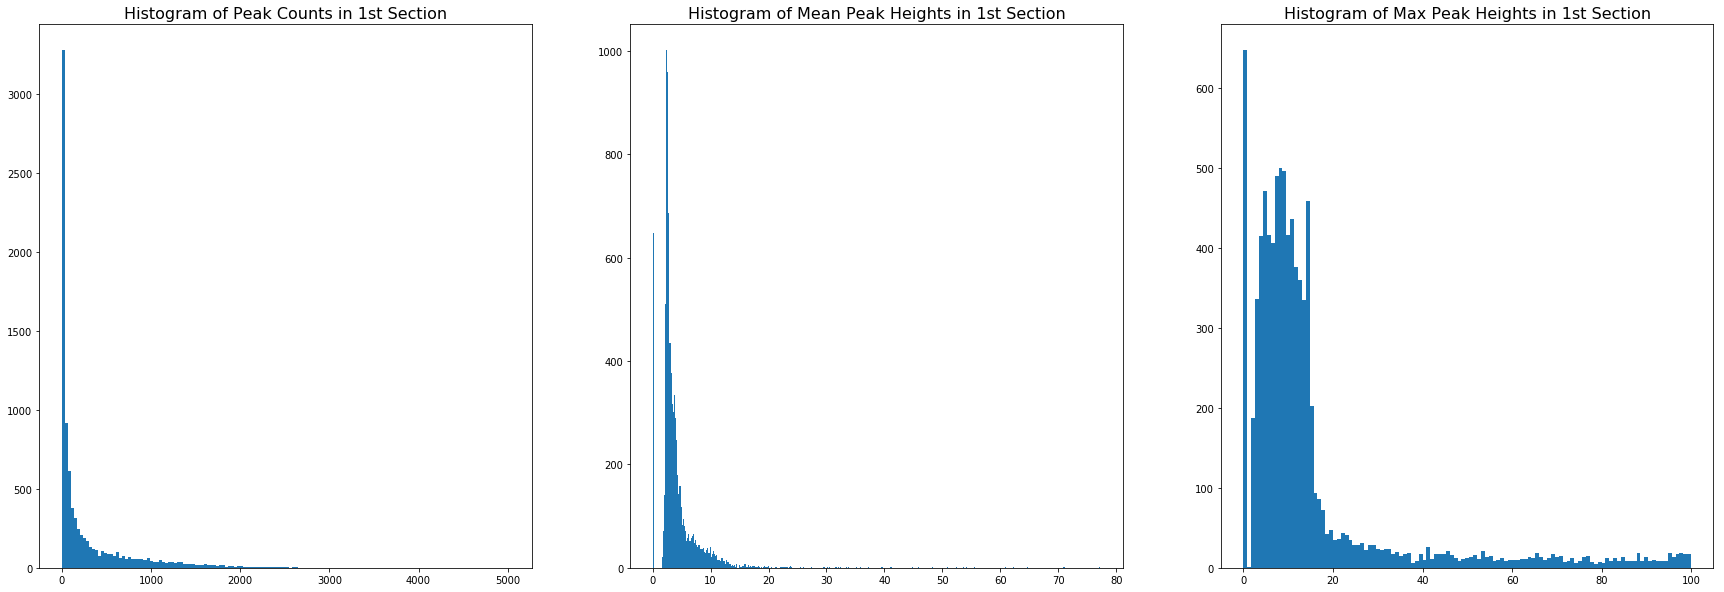

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
    
ax[0].hist(train_features["p1_n"], bins='auto')
ax[0].set_title("Histogram of Peak Counts in 1st Section", fontsize=16)
ax[1].hist(train_features["ph1_mean"], bins='auto')
ax[1].set_title("Histogram of Mean Peak Heights in 1st Section", fontsize=16)
ax[2].hist(train_features["ph1_max"], bins='auto')
ax[2].set_title("Histogram of Max Peak Heights in 1st Section", fontsize=16)

### Import Test Set Metadata

In [17]:
metadata_test = pd.read_csv(data_dir + '/metadata_test.csv')
metadata_test.head()

,signal_id,id_measurement,phase
0,8712,2904,0
1,8713,2904,1
2,8714,2904,2
3,8715,2905,0
4,8716,2905,1


# Test Set: Load, Filter, Denoise, and Extract Features 
**Note: this is done in 10 parts in order to not exceed available RAM**  

In [18]:
%%time

first_index = metadata_test.signal_id[0]
length_test = metadata_test.shape[0]  #20337
n_parts = 10
step_size = int(length_test/n_parts)
last_step = length_test % n_parts

# Create a list of lists with start index and end index for each of the 10 parts and one for the last partial part
start_end = [[x, x+step_size] for x in range(first_index, length_test + first_index, step_size)]
start_end = start_end[:-1] + [[start_end[-1][0], start_end[-1][0] + last_step]]
# print(start_end)

peak_height = (2,100)
rel_height = 0.2
test_features = np.empty((length_test, 44))

for start, end in start_end:
    
    subset_test = pq.read_pandas(data_dir + '/test.parquet', columns=[str(x) for x in range(start, end)]).to_pandas()
    
    for i in range(start, end):
        signal_id = str(i)
    
        # Synchronize phases
        x_sync, dominant_frequency = sync_phase(subset_test[signal_id])
    
        # Apply high pass filter with low cutoff of 10kHz
        x_hp = high_pass_filter(x_sync, low_cutoff=10000, sample_rate=sample_rate)
    
        # Apply denoising
        x_dn = denoise_signal(x_hp, wavelet='haar', level=1)
    
        # Peak & valley features, divided into 4 parts of the waveform
        for j in range(4):
            subset_x_dn = x_dn[j*200000:j*200000+200000]
            p, _ = find_peaks(subset_x_dn, height=peak_height, rel_height=rel_height)
            v, _ = find_peaks(-subset_x_dn, height=peak_height, rel_height=rel_height)
            pv = np.sort(np.concatenate((p, v)))
            # If there are no peaks, or the dominant frequancy is not 50Hz, return zeros
            if pv.shape[0] == 0 or dominant_frequency != 50:
                test_features[i-first_index, j*11:j*11+11] = np.zeros(11)
            else:
                # Cancel false peaks
                pv_true, _ = cancel_false_peaks(subset_x_dn, pv, min_height_fp=15)
                # Peak and valley features
                test_features[i-first_index, j*11] = pv_true.shape[0]
                test_features[i-first_index, j*11+1:j*11+11] = pv_features(subset_x_dn, pv_true, p, v, rel_height=rel_height)

# Combine peak/vally features with names
test_features = pd.DataFrame(test_features, columns=feature_columns)
# Add signal_id and id_measurement columns
test_features.insert(loc=0, column="signal_id", value=metadata_test.signal_id)
test_features.insert(loc=1, column="id_measurement", value=metadata_test.id_measurement)
# Save features to CSV
test_features.to_csv('test_features.csv', index=False)


CPU times: user 1h 24min 36s, sys: 2min 36s, total: 1h 27min 12s
Wall time: 1h 27min 13s


# Fit Models
**First Model: Random Forest**  
**Second Model: Random Forest with all three phases grouped together**  
This is because about 80% of faults occur on all three phases in the train data, but this percentage was much lower for test set predictions from the first model  
**Stacked Ensemble Model: Use Logistic Regression to combine the other two models


## Random Forest Model

In [27]:
%%time
# Define features to use (all features at this time)
modeled_features = ["p1_n", "ph1_mean", "ph1_max", "pw1_mean", "pw1_max", "v1_n", "vh1_mean", "vh1_max", "vw1_mean", "vw1_max",
                    "p2_n", "ph2_mean", "ph2_max", "pw2_mean", "pw2_max", "v2_n", "vh2_mean", "vh2_max", "vw2_mean", "vw2_max",
                    "p3_n", "ph3_mean", "ph3_max", "pw3_mean", "pw3_max", "v3_n", "vh3_mean", "vh3_max", "vw3_mean", "vw3_max",
                    "p4_n", "ph4_mean", "ph4_max", "pw4_mean", "pw4_max", "v4_n", "vh4_mean", "vh4_max", "vw4_mean", "vw4_max"
                   ]
X_train = train_features[modeled_features]
# Define target
y_train = metadata_train.target

# Random Forest Classifier
random_state = 1
class_weight = dict({0:0.5, 1:2.0})
RF_classifier = RandomForestClassifier(bootstrap=True, class_weight=class_weight, criterion='gini',
                                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0, min_impurity_split=None,
                                       min_samples_leaf=4, min_samples_split=10,
                                       min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
                                       oob_score=False, random_state=random_state, verbose=0, warm_start=False)
RF_classifier.fit(X_train, y_train)

# k-fold cross validation
mcc_scorer = make_scorer(matthews_corrcoef)
mcc = cross_val_score(estimator = RF_classifier,
                             X = X_train,
                             y = y_train,
                             scoring=mcc_scorer,
                             cv = 10)
print("MCC Mean = ", mcc.mean())
print("MCC SD = ", mcc.std())

## Predict Test Set Target 
X_test = test_features[modeled_features]
y_pred = RF_classifier.predict(X_test)

MCC Mean =  0.6014003698935049
MCC SD =  0.08981433705031791
CPU times: user 15.9 s, sys: 1.27 s, total: 17.1 s
Wall time: 31.9 s


## Grouped Random Forest: Three Phases Grouped Together

In [28]:
# Create grouped train features - take the mean of the three phases
group_train_features = train_features.groupby(["id_measurement"]).mean()
group_train_features.shape
group_X_train = group_train_features[modeled_features]
# Create grouped test features - take the mean of the three phases
group_test_features = test_features.groupby(["id_measurement"]).mean()
group_test_features.shape
# Define target
group_y_train = metadata_train.groupby(["id_measurement"]).median()["target"]  # take median target value

# Grouped Random Forest Classifier
random_state = 1
class_weight = dict({0:0.5, 1:2.0})
group_RF_classifier = RandomForestClassifier(bootstrap=True, class_weight=class_weight, criterion='gini',
                                             max_depth=8, max_features='auto', max_leaf_nodes=None,
                                             min_impurity_decrease=0.0, min_impurity_split=None,
                                             min_samples_leaf=4, min_samples_split=10,
                                             min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
                                             oob_score=False, random_state=random_state, verbose=0, warm_start=False)
group_RF_classifier.fit(group_X_train, group_y_train)

# k-fold cross validation
group_mcc = cross_val_score(estimator = group_RF_classifier,
                             X = group_X_train,
                             y = group_y_train,
                             scoring=mcc_scorer,
                             cv = 10)
print("MCC Mean = ", group_mcc.mean())
print("MCC SD = ", group_mcc.std())

# Grouped Test Set Predictions
group_X_test = group_test_features[modeled_features]
group_y_pred = group_RF_classifier.predict(group_X_test)
group_y_pred = group_y_pred.repeat(3)


MCC Mean =  0.6315854420698475
MCC SD =  0.09014647661276673


# Stacked Ensemble (Meta) Model 
**Logistic Regression**

In [30]:
# Use first two RF models to make predictions on the training sets (only made predictions on the test sets earlier)
meta_X_train1 = RF_classifier.predict(X_train)
meta_X_train2 = np.repeat(group_RF_classifier.predict(group_X_train), 3)
meta_X_train = np.column_stack([meta_X_train1, meta_X_train2])
# Define target
y_train = metadata_train.target

# Logistic Regression (Classifier)
log_classifier = LogisticRegression(random_state = 0)
log_classifier.fit(meta_X_train, y_train)

# k-fold cross validation
meta_mcc = cross_val_score(estimator = log_classifier,
                           X = meta_X_train,
                           y = y_train,
                           scoring=mcc_scorer,
                           cv = 10)
print("MCC Mean = ", meta_mcc.mean())
print("MCC SD = ", meta_mcc.std())

# Predict Test Set Target
meta_X_test = np.column_stack([y_pred, group_y_pred])
meta_y_pred = log_classifier.predict(meta_X_test)
meta_y_pred.mean()

# Prepare Kaggle submission
output = pd.read_csv(data_dir + '/sample_submission.csv')
output['target'] = meta_y_pred
output.to_csv('submission3.csv', index=False)


MCC Mean =  0.8083652690425829
MCC SD =  0.06764916230251698


**My final submission had an MCC of 0.61178**